<a href="https://colab.research.google.com/github/jongkwangyun/quant/blob/main/%ED%95%9C%EA%B5%ADETF_%EB%B0%B1%ED%85%8C%EC%8A%A4%ED%8A%B8_%EC%97%B0%EA%B8%88%EC%A0%80%EC%B6%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install pandas_market_calendars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 8.8 MB/s eta 0:00:00


In [21]:
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import display, Markdown
import csv
import json
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# 데이터 csv 내보내기 사용 여부
is_export_csv = False

# display에서 소수점 4자리까지 표현
pd.options.display.float_format = '{:,.2f}'.format

# display시 DataFrame 모든 열 표시
pd.set_option('display.max_columns', None)

# 데이터 가져올 기간을 지정합니다. (오늘로부터 12개월 전)
today = datetime.today().date()

# 오늘 날짜 string에 저장
str_today = today.strftime('### %Y-%m-%d ')

# 전략명
str_strategy = '한국ETF 연금저축  '

# 오늘 날짜를 가져와서 파일명에 추가
today_date = today.strftime('%y%m%d')
filename = f'{today_date} {str_strategy}.xlsx'

# csv 경로 설정
output_path =  '/content/drive/MyDrive/DynamicAssetAllocation/'

# 월평균영업일수. average Monthly Business Day
MBD = 21

# 전략에 사용할 ETF 명 리스트에 담기
KOR_ETF = {'kodex_snp': '219480.KS',  # KODEX S&P500선물(H)
           'arirang_emerging': '195980.KS',  # ARIRANG 신흥국MSCI(합성H)
           'ace_krx_gld': '411060.KS',  # ACE KRX금현물
           'kodex_gld': '132030.KS',  # Kodex 골드선물(H)
           'kodex_kor_bond_10': '152380.KS',  # KODEX 국채선물10년
           'kodex_usa_bond_10': '308620.KS',  # KODEX 미국채10년선물
           'tiger_short_msb': '157450.KS',  # TIGER 단기통안채
           'tiger_usa_dow': '245340.KS',  # TIGER 미국다우존스30
           'kosef_kor_bond_10': '148070.KS'  # KOSEF 국고채 10년 ('ACE 국고채10년' 대체)
           }

etf_risk = [KOR_ETF['kodex_snp'], KOR_ETF['arirang_emerging'], KOR_ETF['kodex_gld']]
etf_safe = [KOR_ETF['kosef_kor_bond_10'], KOR_ETF['kodex_usa_bond_10'], KOR_ETF['tiger_short_msb']]

# 자산군 리스트 더하기, 중복 제거
etf_order = etf_risk + etf_safe

# ETF 가격 추출
df_etf = yf.download(etf_order, end=today)['Adj Close']\
.sort_index(ascending=False)[etf_order].rename_axis(None, axis=0).dropna()

# columns를 종목명으로 바꾸기
kor_etf_keys = list(KOR_ETF.keys())
item_name = []

for col in list(df_etf.columns):
  item_name.append(kor_etf_keys[(list(KOR_ETF.values()).index(col))])

df_etf.columns = item_name

display(df_etf)

[*********************100%%**********************]  6 of 6 completed


,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2023-12-05,"21,195.00","8,780.00","12,905.00","112,365.00","10,945.00","105,325.00"
2023-12-04,"21,315.00","8,935.00","13,220.00","112,165.00","10,885.00","105,320.00"
2023-12-01,"21,230.00","8,785.00","12,965.00","111,525.00","10,840.00","105,305.00"
2023-11-30,"21,200.00","8,745.00","12,970.00","111,355.00","10,735.00","105,290.00"
2023-11-29,"21,200.00","8,725.00","12,990.00","111,970.00","10,745.00","105,260.00"
...,...,...,...,...,...,...
2018-10-25,"12,800.00","9,405.00","9,105.00","119,243.50","10,145.00","100,501.10"
2018-10-24,"13,100.00","9,665.00","9,045.00","118,783.60","10,035.00","100,486.22"
2018-10-23,"13,000.00","9,675.00","9,025.00","118,620.41","10,065.00","100,486.22"
2018-10-22,"13,290.00","9,745.00","9,015.00","118,284.13","9,995.00","100,481.26"


In [38]:
# 5, 11월 첫날 데이터만 산출
df_etf_monthly_index = df_etf.groupby(df_etf.index.to_period("M")).apply(lambda x: x.index.min()).sort_index(ascending=False)
df_etf_monthly = df_etf.groupby(df_etf.index.to_period("M")).apply(lambda x: x.loc[x.index.min()]).sort_index(ascending=False)
df_etf_monthly.index = df_etf_monthly_index
df_etf_monthly = df_etf_monthly[1::6]
df_etf_monthly

,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2023-11-01,"19,505.00","8,295.00","12,610.00","106,240.00","10,775.00","104,950.00"
2023-05-02,"19,755.00","8,915.00","12,915.00","111,830.00","11,660.00","103,265.00"
2022-11-01,"18,655.00","8,150.00","10,915.00","103,473.27","11,995.00","101,540.00"
2022-05-03,"20,115.00","10,105.00","12,515.00","108,467.92","11,415.00","100,815.00"
2021-11-01,"22,175.00","12,065.00","12,060.00","115,643.40","11,685.00","100,375.00"
2021-05-03,"20,110.00","12,825.00","12,105.00","118,318.75","11,255.00","100,185.00"
2020-11-02,"15,675.00","10,745.00","12,975.00","124,361.78","11,800.00","99,945.47"
2020-05-04,"13,390.00","8,810.00","12,090.00","124,168.91","12,745.00","99,672.61"
2019-11-01,"14,550.00","10,505.00","10,815.00","123,738.69","11,315.00","100,570.56"
2019-05-02,"14,015.00","10,840.00","9,215.00","121,577.63","10,790.00","99,836.32"


In [48]:
## DataFrame 만들기: ETF 종목, 종목별 투자 비율
row_count = len(df_etf_monthly)
columns_num = [i for i in range(6)]
df_high_etf = pd.DataFrame(columns=columns_num, index=df_etf_monthly.index)

df_buy_ratio_etf = pd.DataFrame(columns=columns_num, index=df_etf_monthly.index)

# 개별 주식, 국채, 단기채 비율
ratio_11_4 = [0.5, 0.5, 0, 0, 0, 0]
ratio_5_10 = [0.5, 0.5, 0, 0, 0, 0]

for i in reversed(range(row_count)):
  # 5월이면 5-10 비율, else 11월이면 11-4 비율
  if df_etf_monthly.index[i].month == 5:
    df_buy_ratio_etf.iloc[i] = ratio_5_10

  else:
    df_buy_ratio_etf.iloc[i] = ratio_11_4

  df_high_etf.iloc[i] = df_etf_monthly.columns

display(df_high_etf)

# 종목별 투자 비율
df_buy_ratio = df_buy_ratio_etf

str_buy_ratio = str_today + str_strategy + "### ETF 투자 비율"
display(Markdown(str_buy_ratio))
display(df_buy_ratio)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_buy_ratio}\n')
    df_buy_ratio.head(5).to_csv(f, index=True)

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    df_high_etf.head(5).to_csv(f, index=True)

,0,1,2,3,4,5
2023-11-01,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2023-05-02,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2022-11-01,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2022-05-03,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2021-11-01,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2021-05-03,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2020-11-02,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2020-05-04,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2019-11-01,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb
2019-05-02,kodex_snp,arirang_emerging,kodex_gld,kosef_kor_bond_10,kodex_usa_bond_10,tiger_short_msb


### 2023-12-06 한국ETF 연금저축  ### ETF 투자 비율

,0,1,2,3,4,5
2023-11-01,0.50,0.50,0,0,0,0
2023-05-02,0.50,0.50,0,0,0,0
2022-11-01,0.50,0.50,0,0,0,0
2022-05-03,0.50,0.50,0,0,0,0
2021-11-01,0.50,0.50,0,0,0,0
2021-05-03,0.50,0.50,0,0,0,0
2020-11-02,0.50,0.50,0,0,0,0
2020-05-04,0.50,0.50,0,0,0,0
2019-11-01,0.50,0.50,0,0,0,0
2019-05-02,0.50,0.50,0,0,0,0


In [49]:
## 백테스트
monthly_column_count = df_high_etf.shape[1]
monthly_index = df_high_etf.index

# 비율대로 돈 투자
df_invest_money = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_invest_count = pd.DataFrame(columns=[i for i in range(monthly_column_count)], index=monthly_index)
df_cash = pd.DataFrame(columns=['cash'], index=monthly_index)

# 초기자본
invest_cash = 10_000_000

for i in reversed(range(row_count)):
  row_sum = 0

  for j in range(monthly_column_count):
    if i == row_count - 1:
      row_sum = invest_cash
      break
    else:
      sel_etf = df_high_etf.iloc[i+1][j]
      row_sum += df_invest_count.iloc[i+1][j] * df_etf_monthly.iloc[i][sel_etf]

  for j in range(monthly_column_count):
    df_cash.iloc[i][0] = row_sum
    sel_etf = df_high_etf.iloc[i][j]
    sel_etf_price = df_etf_monthly.iloc[i][sel_etf]
    sel_etf_buy_count = df_cash.iloc[i][0] * df_buy_ratio.iloc[i][j] / sel_etf_price
    df_invest_count.iloc[i][j] = sel_etf_buy_count

display(Markdown(str_today + str_strategy + '### ETF 구매 개수'))
display(df_invest_count)
display(Markdown(str_today + str_strategy + '### 평가 금액'))
display(df_cash)

### 2023-12-06 한국ETF 연금저축  ### ETF 구매 개수

,0,1,2,3,4,5
2023-11-01,294.15,691.68,0.00,0.00,0.00,0.00
2023-05-02,302.88,671.16,0.00,0.00,0.00,0.00
2022-11-01,297.97,682.04,0.00,0.00,0.00,0.00
2022-05-03,318.74,634.49,0.00,0.00,0.00,0.00
2021-11-01,331.45,609.20,0.00,0.00,0.00,0.00
2021-05-03,357.72,560.92,0.00,0.00,0.00,0.00
2020-11-02,370.63,540.68,0.00,0.00,0.00,0.00
2020-05-04,363.03,551.76,0.00,0.00,0.00,0.00
2019-11-01,379.88,526.15,0.00,0.00,0.00,0.00
2019-05-02,392.95,508.05,0.00,0.00,0.00,0.00


### 2023-12-06 한국ETF 연금저축  ### 평가 금액

,cash
2023-11-01,"11,474,979.49"
2023-05-02,"11,966,820.19"
2022-11-01,"11,117,289.95"
2022-05-03,"12,823,089.29"
2021-11-01,"14,699,905.49"
2021-05-03,"14,387,509.69"
2020-11-02,"11,619,167.42"
2020-05-04,"9,721,987.18"
2019-11-01,"11,054,476.18"
2019-05-02,"11,014,442.39"


## 2023-12-06  한국ETF 연금저축   ## CAGR: 2.79 %

### 5-10 비율: 0.5 0.5 0 0 0 0

### 11-4 비율: 0.5 0.5 0 0 0 0

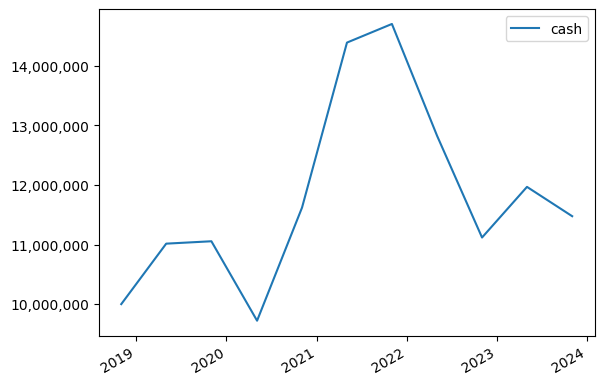

In [50]:
# 그래프 그리기
ax = df_cash.plot()

# Y 축 레이블 포맷팅 함수
def format_yticks(value, _):
    return '{:,.0f}'.format(value)

# Y 축 레이블 포맷팅 적용
ax.yaxis.set_major_formatter(FuncFormatter(format_yticks))

month_count_in_year = 2

CAGR = str(round(((df_cash.iloc[0][0] / df_cash.iloc[-1][0]) ** (month_count_in_year/(row_count-1)) - 1)*100, 2))
display(Markdown(f'{str_today[1:]} {str_strategy} ## CAGR: {CAGR} %'))

display(Markdown(f'### 5-10 비율: {" ".join(map(str, ratio_5_10))}'))
display(Markdown(f'### 11-4 비율: {" ".join(map(str, ratio_11_4))}'))

# 그래프 출력
plt.show()

# csv에 제목 및 DataFrame 추가
if is_export_csv:
  with open(output_path + filename, 'a') as f:
    f.write('\n')
    f.write(f'{str_today[1:] + str_strategy}\n')